# NHWC vs. NCHW
>"On GPU, NCHW is faster. But on CPU, NHWC is sometimes faster." [(source)](https://www.tensorflow.org/performance/performance_models#build_the_model_with_both_nhwc_and_nchw)

When computing convolutions, we can consider each tensor element as a struct with multiple features (e.g. one per image color) but we could also view each feature as part of an individual feature map. Depending on how we order the input tensor we'll get slightly different execution paths. Essentially it comes down to the order of computation and cache locality (in rough pseudo code):

```python
# NHWC
for i in rows
    for j in columns
        for k in filters

# NCHW
for k in filters
    for i in rows
        for j in columns
```
However, due to such a convoluted and deep toolchain (puns intended) it is really hard to know what the end result will be in terms of actual wall time. Benchmarking is the best way of getting a feel for how much we need to care about designing models that work with both data formats. The type of network that should benefit the most from the right ordering is something like [VGG16](https://arxiv.org/abs/1409.1556) that has a huge amount of convolution kernels compared to more modern architectures, so let's benchmark that one, because it will give us a decent upper bound on what performance differences we should expect.

In [1]:
import tensorflow as tf

tf.VERSION

'1.9.0-dev20180607'

In [2]:
from tensorflow.python.keras import *
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.applications import *


def create_model():
    backend.clear_session()

    base_model = VGG16(include_top=False)
    inputs = base_model.inputs

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(100, activation='softmax')(x)

    outputs = [x]
    model = Model(inputs, outputs)
    model.compile('adam', 'sparse_categorical_crossentropy')
    return model

In [3]:
backend.set_image_data_format('channels_first')
x_train, y_train = datasets.cifar100.load_data()[0]
model = create_model()
nchw = %timeit -o -r10 model.fit(x_train, y_train)

Epoch 1/1
50000/50000 [==============================] - 50s 1ms/step - loss: 15.9570
Epoch 1/1
50000/50000 [==============================] - 44s 878us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 44s 878us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 44s 877us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 44s 879us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 44s 886us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 44s 883us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 44s 883us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 44s 879us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 44s 881us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 44s 878us/step - loss: 15.9569
44 s ± 141 ms per loop (mean ± std

In [4]:
backend.set_image_data_format('channels_last')
x_train, y_train = datasets.cifar100.load_data()[0]
model = create_model()
nhwc = %timeit -o -r10 model.fit(x_train, y_train)

Epoch 1/1
50000/50000 [==============================] - 49s 976us/step - loss: 15.9564
Epoch 1/1
50000/50000 [==============================] - 45s 902us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 45s 902us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 45s 905us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 45s 904us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 45s 901us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 45s 900us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 45s 901us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 45s 900us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 45s 900us/step - loss: 15.9569
Epoch 1/1
50000/50000 [==============================] - 45s 896us/step - loss: 15.9569
45.1 s ± 118 ms per loop (mean ±

## Results

'Channels first is 2.39% faster.'

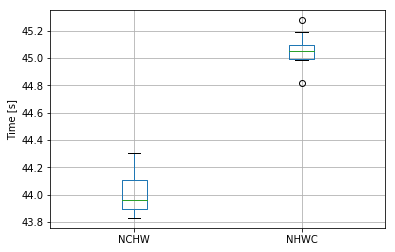

In [63]:
%matplotlib inline
import pandas as pd

df = pd.DataFrame({'NCHW': nchw.all_runs, 'NHWC': nhwc.all_runs})
ax = df.boxplot()
ax.set_ylabel('Time [s]')

means = df.mean()
ratio = means.NHWC / means.NCHW
f'Channels first is {100*(ratio - 1):.2f}% faster.'

## Conclusion
As we can see above, TensorFlow's documentation isn't wrong when training a VGG-esque network (_lots_ of convolution filters) on a GPU. However the difference in performance is minor so I personally wouldn't bother with it. Hopefully XLA will be turned on by default eventually and its HLO could take care of this performance gap for us. Also, keep in mind that for control-flow heavy models such as RNNs the results would probably be even blurrier.

